In [2]:
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime

# === Setup ===
headers = {"User-Agent": "Kamil Aksoy kamil.aksoy@usi.ch"}
input_csv = "/Users/kamilaksoy/Desktop/thesis/data/SP500.csv"
save_base_dir = "/Users/kamilaksoy/Desktop/thesis/data/Industry_10K_Reports"
cik_lookup_url = "https://www.sec.gov/files/company_tickers.json"

# Load CIK map from SEC
cik_data = requests.get(cik_lookup_url, headers=headers).json()
cik_map = {entry['ticker']: str(entry['cik_str']).zfill(10) for entry in cik_data.values()}

# Load and clean input data
df = pd.read_csv(input_csv)
df.columns = df.columns.str.strip()
df["Ticker"] = df["Ticker"].str.upper().str.strip().str.replace(".", "-", regex=False)
df["Company Name"] = df["Company Name"].str.strip()
df["GICS IndustryGroup"] = df["GICS IndustryGroup"].str.strip()

# Sort industry groups and enumerate
industry_groups = sorted(df["GICS IndustryGroup"].dropna().unique())

def get_quarter(filing_date):
    try:
        dt = pd.to_datetime(filing_date)
        return f"Q{((dt.month-1)//3)+1} {dt.year}"
    except:
        return "Unknown"

def fetch_10k_data(ticker, company_name, subindustry_id):
    cik = cik_map.get(ticker)
    if not cik:
        return None, {"Ticker": ticker, "Company": company_name, "Error": "CIK not found", "SubIndustryId": subindustry_id}

    sub_url = f"https://data.sec.gov/submissions/CIK{cik}.json"
    try:
        data = requests.get(sub_url, headers=headers).json()
        filings = data["filings"]["recent"]
        for i, form in enumerate(filings["form"]):
            if form == "10-K":
                acc_num = filings["accessionNumber"][i].replace("-", "")
                file_name = filings["primaryDocument"][i]
                filing_date = filings["filingDate"][i]
                report_date = filings["reportDate"][i]
                file_url = f"https://www.sec.gov/Archives/edgar/data/{int(cik)}/{acc_num}/{file_name}"
                html = requests.get(file_url, headers=headers).text
                soup = BeautifulSoup(html, "html.parser")
                text = soup.get_text(separator="\n")
                return text, {
                    "Company": company_name,
                    "Ticker": ticker,
                    "CIK": cik,
                    "Filing Date": filing_date,
                    "Reporting Date": report_date,
                    "Quarter": get_quarter(filing_date),
                    "SubIndustryId": subindustry_id
                }
        return None, {"Ticker": ticker, "Company": company_name, "Error": "No 10-K found", "SubIndustryId": subindustry_id}
    except Exception as e:
        return None, {"Ticker": ticker, "Company": company_name, "Error": str(e), "SubIndustryId": subindustry_id}

# === Run for each Industry Group ===
os.makedirs(save_base_dir, exist_ok=True)

for ig_idx, industry in enumerate(industry_groups, start=1):
    print(f"\n🔍 Processing Industry Group [{ig_idx}]: {industry}")
    group_df = df[df["GICS IndustryGroup"] == industry].copy()
    group_df = group_df.sort_values(by="Company Name").reset_index(drop=True)
    
    results = []
    industry_folder = os.path.join(save_base_dir, f"{ig_idx:02d}_{industry.replace(' ', '_')}_10Ks")
    os.makedirs(industry_folder, exist_ok=True)
    metadata_path = os.path.join(save_base_dir, f"{ig_idx:02d}_{industry.replace(' ', '_')}_10k_metadata.csv")

    for i, row in group_df.iterrows():
        name = row["Company Name"]
        ticker = row["Ticker"]
        subindustry_id = row["GICS Sub-IndustryId"]
        
        print(f"   {i+1:>2}. {ticker} - {name}")
        text, metadata = fetch_10k_data(ticker, name, subindustry_id)
        results.append(metadata)

        if text:
            fname = f"{ticker}_10K_{metadata.get('Reporting Date', 'unknown')}.txt"
            with open(os.path.join(industry_folder, fname), "w", encoding="utf-8") as f:
                f.write(text)

    # Save metadata CSV
    final_df = pd.DataFrame(results)
    final_df.insert(0, "No", range(1, len(final_df) + 1))
    final_df.to_csv(metadata_path, index=False)

    print(f"✅ Metadata saved to: {metadata_path}")
    print(f"📂 Reports saved to folder: {industry_folder}")


🔍 Processing Industry Group [1]: Automobiles & Components
    1. APTV - Aptiv
    2. F - Ford Motor Company
    3. GM - General Motors
    4. TSLA - Tesla, Inc.
✅ Metadata saved to: /Users/kamilaksoy/Desktop/thesis/data/Industry_10K_Reports/01_Automobiles_&_Components_10k_metadata.csv
📂 Reports saved to folder: /Users/kamilaksoy/Desktop/thesis/data/Industry_10K_Reports/01_Automobiles_&_Components_10Ks

🔍 Processing Industry Group [2]: Banks
    1. BAC - Bank of America
    2. C - Citigroup
    3. CFG - Citizens Financial Group
    4. FITB - Fifth Third Bancorp
    5. HBAN - Huntington Bancshares
    6. JPM - JPMorgan Chase
    7. KEY - KeyCorp
    8. MTB - M&T Bank
    9. PNC - PNC Financial Services
   10. RF - Regions Financial Corporation
   11. TFC - Truist Financial
   12. USB - U.S. Bancorp
   13. WFC - Wells Fargo
✅ Metadata saved to: /Users/kamilaksoy/Desktop/thesis/data/Industry_10K_Reports/02_Banks_10k_metadata.csv
📂 Reports saved to folder: /Users/kamilaksoy/Desktop/thesis/

In [4]:
import os
import pandas as pd

# === Define base directory ===
base_dir = "/Users/kamilaksoy/Desktop/thesis/data/Industry_10K_Reports"

# === List all metadata files ===
metadata_files = [
    os.path.join(base_dir, f)
    for f in os.listdir(base_dir)
    if f.endswith("_metadata.csv")
]

# === Load and merge with GICS IndustryGroup extracted from filename ===
all_data = []

for path in metadata_files:
    df = pd.read_csv(path)
    
    # Extract industry group name from filename
    filename = os.path.basename(path)
    group = filename.split("_metadata.csv")[0]
    group_clean = group.split("_")[-1]  # Last part after underscore
    gics_group = filename.split("_", 1)[1].replace("_metadata.csv", "").replace("_", " ")
    
    # Add IndustryGroup column
    df["IndustryGroup"] = gics_group.replace("10k", "").strip()
    
    all_data.append(df)

# === Combine and sort ===
combined_df = pd.concat(all_data, ignore_index=True)
combined_df = combined_df.sort_values(by=["IndustryGroup", "Company"]).reset_index(drop=True)
if "No" in combined_df.columns:
    combined_df.drop(columns="No", inplace=True)

combined_df.insert(0, "No", range(1, len(combined_df) + 1))

# === Save the result ===
output_path = "/Users/kamilaksoy/Desktop/thesis/data/all_industry_metadata_combined.csv"
combined_df.to_csv(output_path, index=False)
print(f"✅ Combined metadata saved to:\n{output_path}")

✅ Combined metadata saved to:
/Users/kamilaksoy/Desktop/thesis/data/all_industry_metadata_combined.csv


In [5]:
import os
import pandas as pd
import re
from datetime import datetime

# === Setup ===
metadata_path = "/Users/kamilaksoy/Desktop/thesis/data/all_industry_metadata_combined.csv"
reports_base = "/Users/kamilaksoy/Desktop/thesis/data/Industry_10K_Reports"
output_csv = "/Users/kamilaksoy/Desktop/thesis/data/ai_mentions_table_updated.csv"

# === AI Keywords ===
ai_keywords = [
    "artificial intelligence", "machine learning", "deep learning", "neural network",
    "generative ai", "natural language processing", "reinforcement learning",
    "large language model", "AI", "ML", "LLM"
]

# === Step 1: Load Metadata ===
df_meta = pd.read_csv(metadata_path)
df_meta["CIK"] = df_meta["CIK"].astype(str).str.zfill(10)
df_meta["Ticker"] = df_meta["Ticker"].str.upper().str.strip()

# === Step 2: Create Quarter Column ===
df_meta["Filing Date"] = pd.to_datetime(df_meta["Filing Date"], errors='coerce')
df_meta["Quarter"] = df_meta["Filing Date"].dt.to_period("Q").astype(str)

# === Step 3: Count AI Mentions ===
records = []

for _, row in df_meta.iterrows():
    ticker = row["Ticker"]
    cik = row["CIK"]
    report_date = str(row["Reporting Date"]).split()[0]
    filename = f"{ticker}_10K_{report_date}.txt"

    txt_path = None
    for root, _, files in os.walk(reports_base):
        for f in files:
            if f == filename:
                txt_path = os.path.join(root, f)
                break
        if txt_path:
            break

    if not txt_path or not os.path.exists(txt_path):
        continue

    try:
        with open(txt_path, "r", encoding="utf-8", errors="ignore") as file:
            content = file.read()

        keyword_counts = {
            kw: len(re.findall(rf"\b{re.escape(kw)}\b", content, flags=re.IGNORECASE))
            for kw in ai_keywords
        }

        total_mentions = sum(keyword_counts.values())

        record = {
            "Company": row["Company"],
            "Ticker": ticker,
            "CIK": cik,
            "Quarter": row["Quarter"],
            "IndustryGroup": row.get("IndustryGroup", ""),
            "AI Mentions": total_mentions
        }
        record.update(keyword_counts)
        records.append(record)

    except Exception as e:
        print(f"❌ Error processing {filename}: {e}")

# === Step 4: Create & Save Final Table ===
df_result = pd.DataFrame(records)
df_result = df_result.sort_values(by=["IndustryGroup", "Company"]).reset_index(drop=True)
df_result.insert(0, "No", range(1, len(df_result) + 1))

df_result.to_csv(output_csv, index=False)
print(f"✅ AI mentions table saved to:\n{output_csv}")

✅ AI mentions table saved to:
/Users/kamilaksoy/Desktop/thesis/data/ai_mentions_table_updated.csv


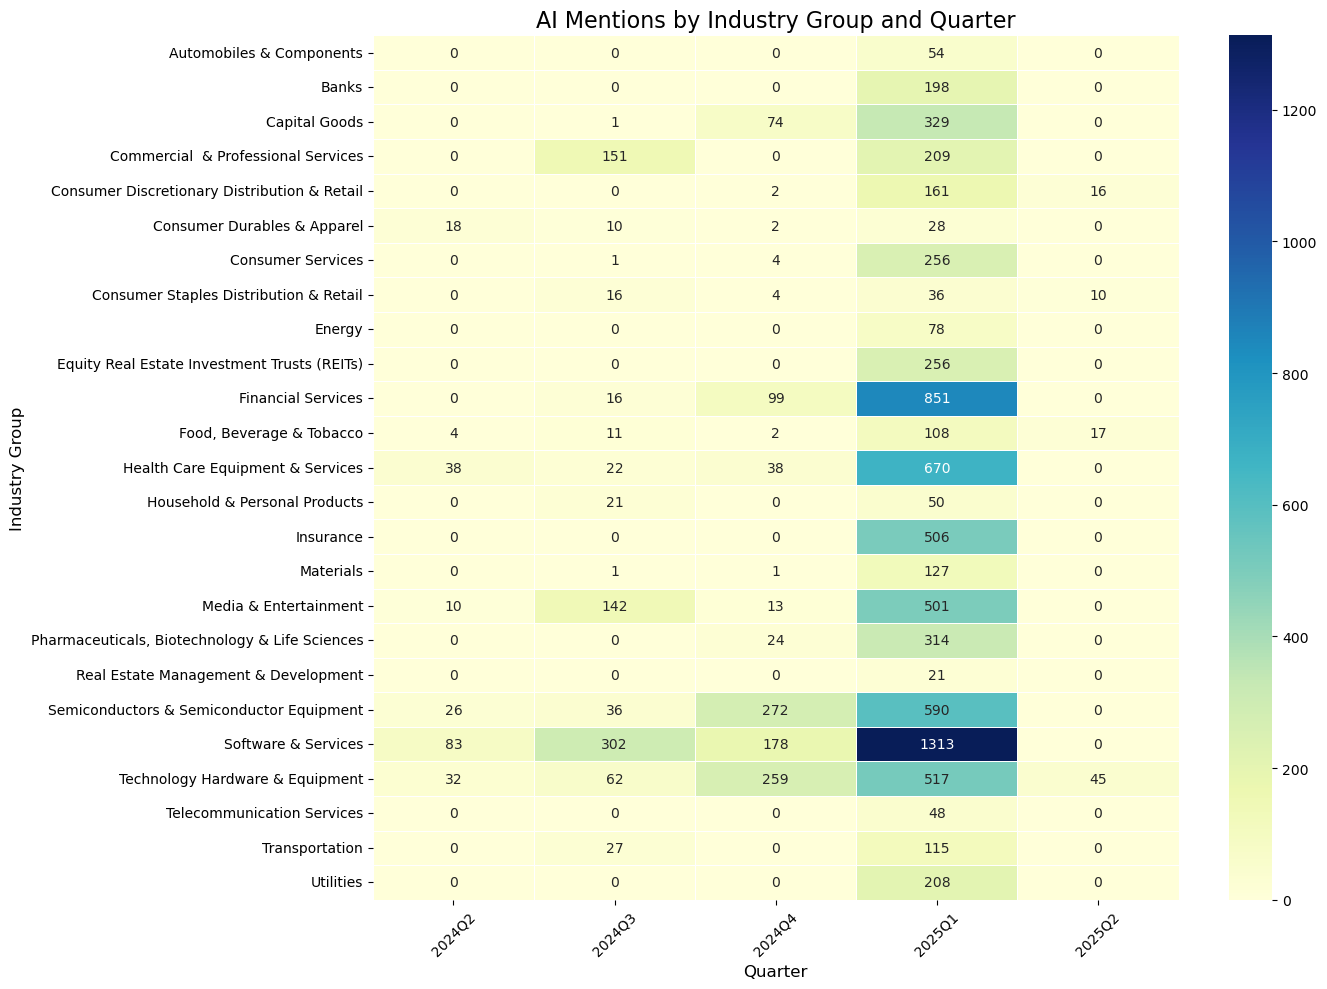

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Paths ===
input_csv = "/Users/kamilaksoy/Desktop/thesis/data/ai_mentions_table_updated.csv"

# === Load data ===
df = pd.read_csv(input_csv)

# === Summarize mentions by IndustryGroup and Quarter ===
pivot_df = df.groupby(["IndustryGroup", "Quarter"])["AI Mentions"].sum().unstack(fill_value=0)

# === Plot Heatmap ===
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_df, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5)

plt.title("AI Mentions by Industry Group and Quarter", fontsize=16)
plt.xlabel("Quarter", fontsize=12)
plt.ylabel("Industry Group", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

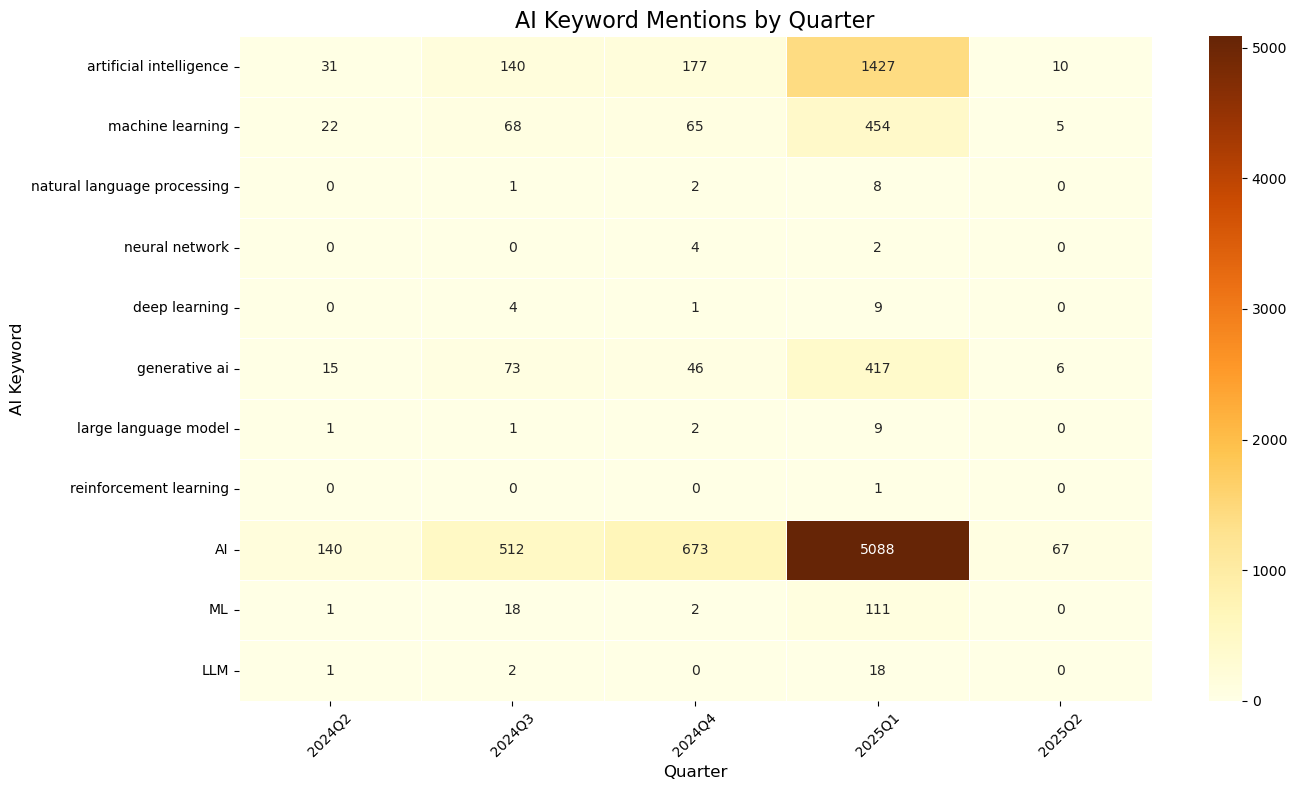

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === File path ===
input_csv = "/Users/kamilaksoy/Desktop/thesis/data/ai_mentions_table_updated.csv"

# === Load data ===
df = pd.read_csv(input_csv)

# === List of AI keywords ===
ai_keywords = [
    "artificial intelligence", "machine learning", "natural language processing",
    "neural network", "deep learning", "generative ai", "large language model",
    "reinforcement learning", "AI", "ML", "LLM"
]

# === Keep only columns that exist in df and are in the keyword list ===
existing_keywords = [kw for kw in ai_keywords if kw in df.columns]
df_keywords = df[["Quarter"] + existing_keywords]

# === Group by Quarter and sum ===
pivot_df = df_keywords.groupby("Quarter")[existing_keywords].sum().T

# === Plot heatmap ===
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_df, annot=True, fmt="d", cmap="YlOrBr", linewidths=.5)

plt.title("AI Keyword Mentions by Quarter", fontsize=16)
plt.xlabel("Quarter", fontsize=12)
plt.ylabel("AI Keyword", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [8]:
import os
import pandas as pd
import re
from datetime import datetime

# === Paths ===
metadata_path = "/Users/kamilaksoy/Desktop/thesis/data/all_industry_metadata_combined.csv"
reports_base_path = "/Users/kamilaksoy/Desktop/thesis/data/Industry_10K_Reports"
output_csv_path = "/Users/kamilaksoy/Desktop/thesis/data/ai_keyword_sentences.csv"

# === AI Keywords ===
ai_keywords = [
    "artificial intelligence", "machine learning", "natural language processing",
    "neural network", "deep learning", "generative ai", "large language model",
    "reinforcement learning", "ai", "ml", "llm"
]

# === Load metadata ===
df = pd.read_csv(metadata_path)
df["Ticker"] = df["Ticker"].str.upper()
df["Filing Date"] = pd.to_datetime(df["Filing Date"])
df["Quarter"] = df["Filing Date"].dt.to_period("Q").astype(str)

# === Function to extract and highlight keyword sentences ===
def extract_sentences(text, keywords):
    sentences = re.split(r'(?<=[.!?])\s+', text)
    matches = []
    for sentence in sentences:
        for kw in keywords:
            pattern = rf"\b{re.escape(kw)}\b"
            if re.search(pattern, sentence, re.IGNORECASE):
                highlighted = re.sub(pattern, r"**\g<0>**", sentence, flags=re.IGNORECASE)
                matches.append((kw.lower(), highlighted.strip()))
    return matches

# === Extract sentences across reports ===
results = []

for _, row in df.iterrows():
    ticker = row["Ticker"]
    report_date = str(row["Reporting Date"]).split()[0]
    cik = str(row["CIK"])
    quarter = row["Quarter"]
    filename = f"{ticker}_10K_{report_date}.txt"
    
    txt_path = None
    for root, _, files in os.walk(reports_base_path):
        if filename in files:
            txt_path = os.path.join(root, filename)
            break
    if not txt_path or not os.path.exists(txt_path):
        continue

    with open(txt_path, "r", encoding="utf-8", errors="ignore") as f:
        text = f.read()
        matches = extract_sentences(text, ai_keywords)
        for keyword, sentence in matches:
            results.append({
                "Company": row["Company"],
                "Ticker": ticker,
                "CIK": cik,
                "Filing Date": row["Filing Date"].date(),
                "Quarter": quarter,
                "AI Keyword": keyword,
                "Matched Sentence": sentence
            })

# === Save output ===
df_sentences = pd.DataFrame(results)
df_sentences.to_csv(output_csv_path, index=False)
print(f"✅ Saved highlighted AI keyword sentences to:\n{output_csv_path}")

✅ Saved highlighted AI keyword sentences to:
/Users/kamilaksoy/Desktop/thesis/data/ai_keyword_sentences.csv


In [9]:
!pip install XlsxWriter

In [10]:
import pandas as pd
import xlsxwriter
import re

# === File paths ===
input_csv = "/Users/kamilaksoy/Desktop/thesis/data/ai_keyword_sentences.csv"
output_xlsx = "/Users/kamilaksoy/Desktop/thesis/data/ai_keyword_sentences_bold_keywords.xlsx"

# === Load data ===
df = pd.read_csv(input_csv)

# === AI keywords ===
ai_keywords = [
    "artificial intelligence", "machine learning", "deep learning",
    "natural language processing", "neural network", "generative ai",
    "large language model", "reinforcement learning", "ai", "ml", "llm"
]

# Create regex pattern to match whole words (case-insensitive)
pattern = re.compile(r'\b(' + '|'.join(re.escape(k) for k in ai_keywords) + r')\b', flags=re.IGNORECASE)

# === Create Excel file with formatting ===
workbook = xlsxwriter.Workbook(output_xlsx)
worksheet = workbook.add_worksheet("AI Sentences")

# Formats
bold_format = workbook.add_format({'bold': True})
normal_format = workbook.add_format()

# === Write headers ===
for col_num, col_name in enumerate(df.columns):
    worksheet.write(0, col_num, col_name, bold_format)

# === Write rows with AI keywords in bold ===
for row_num, row in enumerate(df.itertuples(index=False), start=1):
    for col_num, value in enumerate(row):
        if df.columns[col_num] == "Matched Sentence" and isinstance(value, str):
            parts = []
            last = 0
            for match in pattern.finditer(value):
                start, end = match.span()
                if start > last:
                    parts.append(value[last:start])
                parts.append(bold_format)
                parts.append(value[start:end])
                last = end
            if last < len(value):
                parts.append(value[last:])
            worksheet.write_rich_string(row_num, col_num, *parts)
        else:
            worksheet.write(row_num, col_num, value, normal_format)

# Auto-adjust column widths
for col_num in range(len(df.columns)):
    column_data = [str(cell) for cell in df.iloc[:, col_num].values]
    max_len = max([len(str(df.columns[col_num]))] + [len(x) for x in column_data])
    worksheet.set_column(col_num, col_num, max_len + 2)

workbook.close()

print(f"✅ Excel file with bolded AI keywords saved to:\n{output_xlsx}")

✅ Excel file with bolded AI keywords saved to:
/Users/kamilaksoy/Desktop/thesis/data/ai_keyword_sentences_bold_keywords.xlsx


In [11]:
import pandas as pd

# === File paths ===
metadata_path = "/Users/kamilaksoy/Desktop/thesis/data/all_industry_metadata_combined.csv"
ai_mentions_path = "/Users/kamilaksoy/Desktop/thesis/data/ai_keyword_sentences.csv"
output_path = "/Users/kamilaksoy/Desktop/thesis/data/companies_without_ai_mentions.csv"

# === Load metadata and AI sentences ===
metadata_df = pd.read_csv(metadata_path)
ai_df = pd.read_csv(ai_mentions_path)

# === Ensure ticker column is clean ===
metadata_df["Ticker"] = metadata_df["Ticker"].str.upper().str.strip()
ai_df["Ticker"] = ai_df["Ticker"].str.upper().str.strip()

# === Get tickers with AI mentions ===
tickers_with_ai = ai_df["Ticker"].unique()

# === Filter companies with no AI mentions ===
no_ai_df = metadata_df[~metadata_df["Ticker"].isin(tickers_with_ai)].copy()

# === Optional: sort and reset index ===
no_ai_df = no_ai_df.sort_values(by=["IndustryGroup", "Company"]).reset_index(drop=True)

# === Insert "No" column if not exists ===
if "No" in no_ai_df.columns:
    no_ai_df.drop(columns=["No"], inplace=True)

no_ai_df.insert(0, "No", range(1, len(no_ai_df) + 1))

# === Save to CSV ===
no_ai_df.to_csv(output_path, index=False)
print(f"✅ Companies without AI mentions saved to:\n{output_path}")

✅ Companies without AI mentions saved to:
/Users/kamilaksoy/Desktop/thesis/data/companies_without_ai_mentions.csv


In [12]:
print(df.columns.tolist())

['Company', 'Ticker', 'CIK', 'Filing Date', 'Quarter', 'AI Keyword', 'Matched Sentence']


In [13]:
import pandas as pd

# Load only necessary columns in chunks
input_path = "/Users/kamilaksoy/Desktop/thesis/data/ai_mentions_table_updated.csv"
output_path = "/Users/kamilaksoy/Desktop/thesis/data/companies_with_ai_mentions_only.csv"

chunks = []
for chunk in pd.read_csv(input_path, chunksize=500):
    chunk = chunk[chunk["AI Mentions"] > 0]
    chunks.append(chunk)

# Combine all filtered chunks
result_df = pd.concat(chunks, ignore_index=True)

# Save the filtered results
result_df.to_csv(output_path, index=False)
print(f"✅ Saved filtered companies with AI mentions to:\n{output_path}")

✅ Saved filtered companies with AI mentions to:
/Users/kamilaksoy/Desktop/thesis/data/companies_with_ai_mentions_only.csv


In [14]:
import pandas as pd

# === File paths ===
input_path = "/Users/kamilaksoy/Desktop/thesis/data/ai_mentions_table_updated.csv"
output_path = "/Users/kamilaksoy/Desktop/thesis/data/companies_with_ai_mentions_only.csv"

# === Load and filter the DataFrame ===
df = pd.read_csv(input_path)

# Keep only companies with total mentions > 0
df = df[df["AI Mentions"] > 0].copy()

# Sort alphabetically by company name
df = df.sort_values(by="Company").reset_index(drop=True)

# Remove existing "No" column if exists
if "No" in df.columns:
    df.drop(columns=["No"], inplace=True)

# Insert new "No" column starting from 1
df.insert(0, "No", range(1, len(df) + 1))

# Save to CSV
df.to_csv(output_path, index=False)
print(f"✅ Alphabetically ordered and renumbered file saved to:\n{output_path}")

✅ Alphabetically ordered and renumbered file saved to:
/Users/kamilaksoy/Desktop/thesis/data/companies_with_ai_mentions_only.csv


In [15]:
import pandas as pd

# === File paths ===
input_path = "/Users/kamilaksoy/Desktop/thesis/data/ai_mentions_table_updated.csv"
output_path = "/Users/kamilaksoy/Desktop/thesis/data/companies_with_ai_mentions_only.csv"
summary_output = "/Users/kamilaksoy/Desktop/thesis/data/ai_mentions_by_industrygroup.csv"

# === Load and filter the DataFrame ===
df = pd.read_csv(input_path)

# Keep only companies with total mentions > 0
df = df[df["AI Mentions"] > 0].copy()

# Sort alphabetically by Company
df = df.sort_values(by="Company").reset_index(drop=True)

# Drop existing "No" column if exists
if "No" in df.columns:
    df.drop(columns=["No"], inplace=True)

# Insert new "No" column starting from 1
df.insert(0, "No", range(1, len(df) + 1))

# Save the full cleaned and ordered table
df.to_csv(output_path, index=False)
print(f"✅ Alphabetically ordered AI mentions table saved to:\n{output_path}")

# === Generate summary: Total AI mentions per GICS Sector ===
sector_summary = df.groupby("IndustryGroup")["AI Mentions"].sum().reset_index()
sector_summary = sector_summary.sort_values(by="AI Mentions", ascending=False)

# Save the summary table
sector_summary.to_csv(summary_output, index=False)
print(f"📊 Sector summary saved to:\n{summary_output}")

✅ Alphabetically ordered AI mentions table saved to:
/Users/kamilaksoy/Desktop/thesis/data/companies_with_ai_mentions_only.csv
📊 Sector summary saved to:
/Users/kamilaksoy/Desktop/thesis/data/ai_mentions_by_industrygroup.csv


In [16]:
import pandas as pd

# === File paths ===
input_path = "/Users/kamilaksoy/Desktop/thesis/data/ai_mentions_table_updated.csv"
output_path = "/Users/kamilaksoy/Desktop/thesis/data/companies_with_ai_mentions_only_by_quarter.csv"
summary_output = "/Users/kamilaksoy/Desktop/thesis/data/ai_mentions_by_quarter.csv"

# === Load and filter the DataFrame ===
df = pd.read_csv(input_path)

# Keep only companies with total mentions > 0
df = df[df["AI Mentions"] > 0].copy()

# Sort alphabetically by Company
df = df.sort_values(by="Company").reset_index(drop=True)

# Drop existing "No" column if exists
if "No" in df.columns:
    df.drop(columns=["No"], inplace=True)

# Insert new "No" column starting from 1
df.insert(0, "No", range(1, len(df) + 1))

# Save the filtered and sorted company-level file
df.to_csv(output_path, index=False)
print(f"✅ Company-level AI mentions (by quarter) saved to:\n{output_path}")

# === Generate summary: Total AI mentions by Quarter ===
quarter_summary = df.groupby("Quarter")["AI Mentions"].sum().reset_index()
quarter_summary = quarter_summary.sort_values(by="Quarter")

# Save the summary
quarter_summary.to_csv(summary_output, index=False)
print(f"📊 Quarterly summary saved to:\n{summary_output}")

✅ Company-level AI mentions (by quarter) saved to:
/Users/kamilaksoy/Desktop/thesis/data/companies_with_ai_mentions_only_by_quarter.csv
📊 Quarterly summary saved to:
/Users/kamilaksoy/Desktop/thesis/data/ai_mentions_by_quarter.csv


In [20]:
df_phrases = pd.read_csv(ai_sentences_path)
print(df_phrases.columns.tolist())


['Company', 'Ticker', 'CIK', 'Filing Date', 'Quarter', 'AI Keyword', 'Matched Sentence']


In [28]:
import os
import re
import pandas as pd

# === Step 1: Define paths ===
base_dir = "/Users/kamilaksoy/Desktop/thesis/data/Industry_10K_Reports"
output_path = "/Users/kamilaksoy/Desktop/thesis/data/full_genai_self_declared_report.csv"

# === Step 2: Define detection rules ===
genai_terms = ["gpt", "chatgpt", "gpt-4", "language model", "llm"]
creation_verbs = ["generated", "written", "drafted", "composed", "produced", "authored"]
self_references = ["we", "our", "the company", "management", "our team", "this report"]

# === Step 3: Load metadata files ===
metadata_files = [
    os.path.join(base_dir, f)
    for f in os.listdir(base_dir)
    if f.endswith("_10k_metadata.csv")
]

metadata_list = []
for file in metadata_files:
    df = pd.read_csv(file)
    df["SourceFile"] = os.path.basename(file)
    metadata_list.append(df)

df_metadata = pd.concat(metadata_list, ignore_index=True)

# === Step 4: Process each report ===
results = []

for i, row in df_metadata.iterrows():
    ticker = row["Ticker"]
    report_date = row["Reporting Date"]
    report_filename = f"{ticker}_10K_{report_date}.txt"

    # Find the report in any subdirectory
    report_path = None
    for root, _, files in os.walk(base_dir):
        if report_filename in files:
            report_path = os.path.join(root, report_filename)
            break

    if not report_path or not os.path.exists(report_path):
        continue

    print(f"🔍 Checking {i+1}/{len(df_metadata)}: {row['Company']} ({ticker})")

    with open(report_path, "r", encoding="utf-8", errors="ignore") as file:
        content = file.read().lower()

    # Split into sentences and check for 3-rule match
    matched_sentences = []
    for sentence in re.findall(r"[^.]*\.[\s]*", content):
        if (
            any(g in sentence for g in genai_terms) and
            any(v in sentence for v in creation_verbs) and
            any(s in sentence for s in self_references)
        ):
            matched_sentences.append(sentence.strip())

    if matched_sentences:
        results.append({
            "Company": row["Company"],
            "Ticker": ticker,
            "Filing Date": row["Filing Date"],
            "Reporting Date": row["Reporting Date"],
            "Matched Sentences": " || ".join(matched_sentences)
        })

# === Step 5: Save results ===
df_results = pd.DataFrame(results)
df_results.to_csv(output_path, index=False)

print(f"✅ Done. Results saved to:\n{output_path}")

🔍 Checking 1/503: Aptiv (APTV)
🔍 Checking 2/503: Ford Motor Company (F)
🔍 Checking 3/503: General Motors (GM)
🔍 Checking 4/503: Tesla, Inc. (TSLA)
🔍 Checking 5/503: Automatic Data Processing (ADP)
🔍 Checking 6/503: Broadridge Financial Solutions (BR)
🔍 Checking 7/503: Cintas (CTAS)
🔍 Checking 8/503: Copart (CPRT)
🔍 Checking 9/503: Dayforce (DAY)
🔍 Checking 10/503: Equifax (EFX)
🔍 Checking 11/503: Leidos (LDOS)
🔍 Checking 12/503: Paychex (PAYX)
🔍 Checking 13/503: Paycom (PAYC)
🔍 Checking 14/503: Republic Services (RSG)
🔍 Checking 15/503: Rollins, Inc. (ROL)
🔍 Checking 16/503: Veralto (VLTO)
🔍 Checking 17/503: Verisk Analytics (VRSK)
🔍 Checking 18/503: Waste Management (WM)
🔍 Checking 19/503: Accenture (ACN)
🔍 Checking 20/503: Adobe Inc. (ADBE)
🔍 Checking 21/503: Akamai Technologies (AKAM)
🔍 Checking 22/503: Ansys (ANSS)
🔍 Checking 23/503: Autodesk (ADSK)
🔍 Checking 24/503: Cadence Design Systems (CDNS)
🔍 Checking 25/503: Cognizant (CTSH)
🔍 Checking 26/503: CrowdStrike (CRWD)
🔍 Checking 